<a href="https://colab.research.google.com/github/aschalew38/Elearning-site/blob/main/TensorFlow_Object_Detection_API_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение объектов на изображениях с помощью TensorFlow Object Detection API

Демонстрационный проект является частью курса "[Програмирование глубоких нейронных сетей на Python](https://www.asozykin.ru/courses/nnpython)".

Для запуска создайте свою копию ноутбука (меню File->Save a copy in Drive...)

## Установка TensorFlow Object Detection API

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!git clone https://github.com/tensorflow/models.git
!cd models/research; protoc object_detection/protos/*.proto --python_out=.
!cd models/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-tk is already the newest version (2.7.14-1).
The following additional packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6 libwebpmux3
  libxslt1.1 python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  liblcms2-utils python-genshi python-lxml-dbg python-lxml-doc python-pil-doc
  python-pil-dbg python-setuptools
The following NEW packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6 libwebpmux3
  libxslt1.1 protobuf-compiler python-bs4 python-chardet python-html5lib
  python-lxml python-olefile python-pil python-pkg-resources python-six
  python-webencodings
0 upgraded, 18 newly installed, 0 to remove and 0 not upgraded.
Need to get 3,751 kB of archives.
After this operation, 14.6 MB of additional disk space will be used.
Get:1 

Selecting previously unselected package python-lxml.
Preparing to unpack .../14-python-lxml_4.0.0-1_amd64.deb ...
Unpacking python-lxml (4.0.0-1) ...
Selecting previously unselected package python-olefile.
Preparing to unpack .../15-python-olefile_0.44-1_all.deb ...
Unpacking python-olefile (0.44-1) ...
Selecting previously unselected package python-pil:amd64.
Preparing to unpack .../16-python-pil_4.1.1-3build2_amd64.deb ...
Unpacking python-pil:amd64 (4.1.1-3build2) ...
Selecting previously unselected package protobuf-compiler.
Preparing to unpack .../17-protobuf-compiler_3.0.0-9ubuntu5_amd64.deb ...
Unpacking protobuf-compiler (3.0.0-9ubuntu5) ...
Setting up liblcms2-2:amd64 (2.7-1ubuntu1) ...
Setting up libjbig0:amd64 (2.1-3.1) ...
Setting up libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Setting up python-pkg-resources (36.2.7-2) ...
Setting up libxslt1.1:amd64 (1.1.29-2.1ubuntu1) ...
Setting up libprotobuf10:amd64 (3.0.0-9ubuntu5) ...
Setting up python-six (1.10.0-4) ...
Processing trigger

remote: Total 20029 (delta 0), reused 0 (delta 0), pack-reused 20026
Receiving objects: 100% (20029/20029), 471.50 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (11738/11738), done.
Checking out files: 100% (2966/2966), done.
..................
----------------------------------------------------------------------
Ran 18 tests in 0.156s

OK


In [ ]:
import sys, os

sys.path.append('models/research')
sys.path.append('models/research/object_detection')

import numpy as np
import six.moves.urllib as urllib
import tarfile
import zipfile
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util

## Загрузка предварительно обученной модели

Загружаем файл с моделью

In [ ]:
model_path = 'http://download.tensorflow.org/models/object_detection/'
model_name = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'

In [ ]:
os.environ['MODEL_PATH']=model_path + model_name + '.tar.gz'
os.environ['MODEL_FILE_NAME']=model_name + '.tar.gz'

In [ ]:
!rm $MODEL_FILE_NAME
!wget $MODEL_PATH
!tar xfz $MODEL_FILE_NAME

rm: cannot remove 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz': No such file or directory
--2018-07-23 09:35:55--  http://download.tensorflow.org/models/object_detection/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.196.128, 2607:f8b0:4001:c1a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.196.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366947246 (350M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 349.95M   166MB/s    in 2.1s    

2018-07-23 09:35:58 (166 MB/s) - ‘ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz’ saved [366947246/366947246]



Загрузка модели в память

In [ ]:
model_file_name =  model_name + '/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(model_file_name, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Загрузка меток классов

In [ ]:
label_map = label_map_util.load_labelmap('models/research/object_detection/data/mscoco_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Методы загрузки изображения и распознавания

Метод для загрузки изображения

In [ ]:
def load_image(image_file_name):
    image = Image.open(image_file_name)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

Метод для поиска объектов на одном изображении

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Запуск поиска объектов
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # Преобразование выходных данных из массивов float32 в нужный формат
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

## Ищем объекты на изображениях

### Коты и собаки

In [ ]:
!wget https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg

--2018-07-23 09:37:01--  https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.16
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54476 (53K) [image/jpeg]
Saving to: ‘woof_meow.jpg’

woof_meow.jpg       100%[===================>]  53.20K  --.-KB/s    in 0.02s   

2018-07-23 09:37:01 (2.21 MB/s) - ‘woof_meow.jpg’ saved [54476/54476]



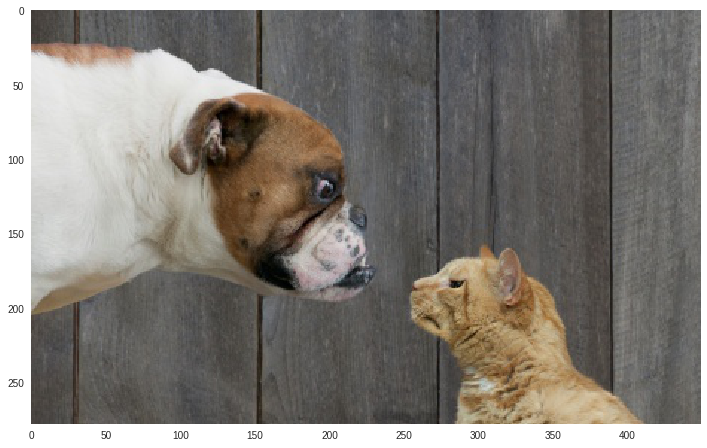

In [ ]:
cat_and_dog = load_image('woof_meow.jpg')
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(cat_and_dog)

### Улица

In [ ]:
!rm street.jpeg
!wget https://github.com/sozykin/dlpython_course/raw/master/computer_vision/object_detection/street.jpeg

--2018-07-23 10:00:04--  https://github.com/sozykin/dlpython_course/raw/master/computer_vision/object_detection/street.jpeg
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sozykin/dlpython_course/master/computer_vision/object_detection/street.jpeg [following]
--2018-07-23 10:00:04--  https://raw.githubusercontent.com/sozykin/dlpython_course/master/computer_vision/object_detection/street.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 527429 (515K) [image/jpeg]
Saving to: ‘street.jpeg’

street.jpeg         100%[===================>] 515.07K  --.-KB/s    in 0.07s   

2018-07-23

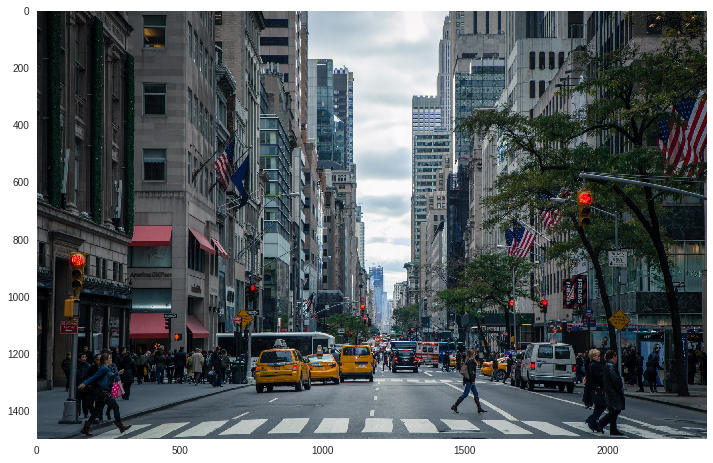

In [ ]:
street = load_image('street.jpeg')
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(street)

Запуск обнаружения объектов

In [ ]:
output_dict = run_inference_for_single_image(street, detection_graph)

Визуализация результатов поиска

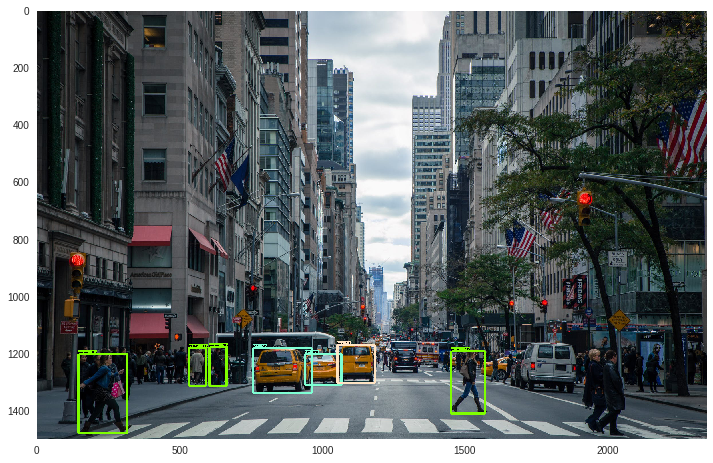

In [ ]:
vis_util.visualize_boxes_and_labels_on_image_array(
      street,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(street)

## Ищем пиксельные маски объектов

TensorFlow Object Detection API может находить объекты с более высокой точностью, чем прямоугольник, в границах которого находится объект. Вместо координат прямоугольника может выдаваться битовая маска. Для этого нужно использовать модели из [TensoFlow Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), у которых в `Outputs` указано значение `Masks` (маски).

In [ ]:
# Загружаем модель с битовой маской на выходе
model_name = 'mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
os.environ['MODEL_PATH']=model_path + model_name + '.tar.gz'
os.environ['MODEL_FILE_NAME']=model_name + '.tar.gz'
!rm $MODEL_FILE_NAME
!wget $MODEL_PATH
!tar xfz $MODEL_FILE_NAME

rm: cannot remove 'mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz': No such file or directory
--2018-07-23 11:10:26--  http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.124.128, 2607:f8b0:4001:c1a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.124.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727390102 (694M) [application/x-tar]
Saving to: ‘mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz’

mask_rcnn_inception 100%[===================>] 693.69M   166MB/s    in 4.2s    

2018-07-23 11:10:31 (166 MB/s) - ‘mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz’ saved [727390102/727390102]



In [ ]:
# Загружаем новую модель в память
model_file_name =  model_name + '/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(model_file_name, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

--2018-07-23 11:14:20--  https://github.com/sozykin/dlpython_course/raw/master/computer_vision/object_detection/car.jpg
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sozykin/dlpython_course/master/computer_vision/object_detection/car.jpg [following]
--2018-07-23 11:14:20--  https://raw.githubusercontent.com/sozykin/dlpython_course/master/computer_vision/object_detection/car.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123001 (120K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>] 120.12K  --.-KB/s    in 0.03s   

2018-07-23 11:14:20 (3.77 

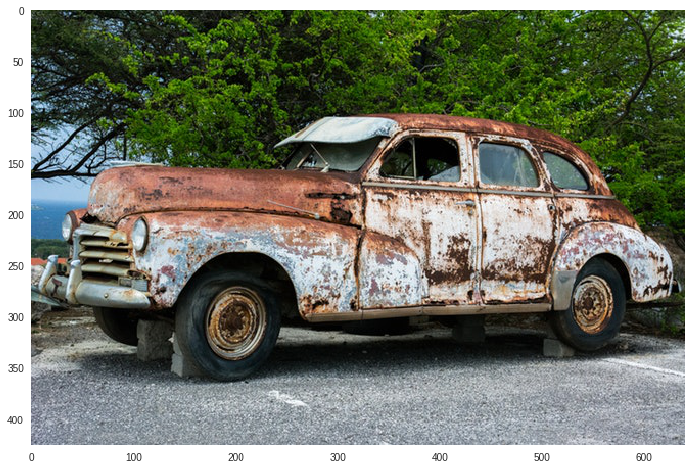

In [ ]:
# Загружаем демонстрационную картинку
!rm car.jpg
!wget https://github.com/sozykin/dlpython_course/raw/master/computer_vision/object_detection/car.jpg
car = load_image('car.jpg')
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(car)

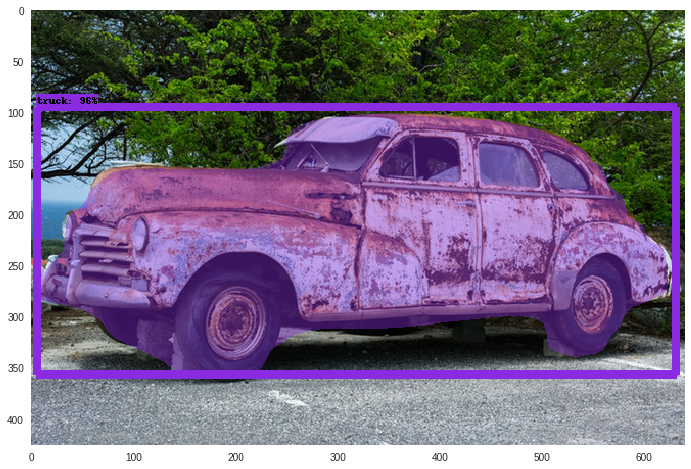

In [ ]:
# Ищем объекты и визуализируем их
output_dict = run_inference_for_single_image(car, detection_graph)
vis_util.visualize_boxes_and_labels_on_image_array(
      car,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(car)
